In [1]:
%matplotlib inline

In [11]:
import os

genome_dir = '../../ibd-genomes-2'
output_dir = '../../output.ibd2'
genbank_genomes = '../../genbank_genomes'
name = 'ZeeviD_2015__PNP_Main_232__bin.27.fa.gz'

In [12]:
import matplotlib.pyplot as plt
import numpy
from collections import defaultdict
import importlib
import pprint
import os
import glob
import yaml

from interval import interval

import screed

import charcoal.alignplot
importlib.reload(charcoal.alignplot)

from charcoal import alignplot
from charcoal.alignplot import AlignmentContainer, StackedDotPlot, AlignmentSlopeDiagram
from charcoal import utils
from charcoal.utils import CSV_DictHelper

from sourmash.lca.command_index import load_taxonomy_assignments

In [13]:
genomebase = name
queryfile = f'{genome_dir}/{genomebase}'
matches_info_file = f'{output_dir}/{genomebase}.hitlist.matches.yaml'

In [14]:
with open(matches_info_file, 'rt') as fp:
    matches_info = yaml.safe_load(fp)
matches_info

genome_lin = utils.make_lineage(matches_info['query_info']['genome_lineage'])

clean_accs = []
dirty_accs = []
for match_acc, acc_info in matches_info['matches'].items():
    match_counts = acc_info['counts']
    match_type = acc_info['match_type']
    match_lineage = acc_info['lineage']

    if match_type == 'clean':
        clean_accs.append((match_acc, match_lineage, match_counts))
    elif match_type == 'dirty':
        dirty_accs.append((match_acc, match_lineage, match_counts))
        
clean_accs.sort(key=lambda x: -x[2])
dirty_accs.sort(key=lambda x: -x[2])

print(f'loaded {len(clean_accs)} clean accs and {len(dirty_accs)} dirty accs')

loaded 10 clean accs and 20 dirty accs


In [16]:
def load_target_pairs(match_list):

    pairs = []
    for acc, _, _ in match_list:
        filename = glob.glob(f'{genbank_genomes}/{acc}*.fna.gz')
        #assert len(filename) == 1, filename # @CTB
        filename = filename[0]
        pairs.append((acc, filename))
        
    print(f'loaded {len(pairs)} pairs for {len(match_list)} accessions')
    return pairs

contaminant_pairs = load_target_pairs(dirty_accs)
clean_pairs = load_target_pairs(clean_accs)

loaded 20 pairs for 20 accessions
loaded 10 pairs for 10 accessions


In [20]:
alignment = AlignmentContainer(genomebase, queryfile, contaminant_pairs, f'{output_dir}/hitlist.acc.csv')

results = {}
for t_acc, _ in contaminant_pairs:
    mashmap_file = f'{output_dir}/{genomebase}.x.{t_acc}.mashmap.out'
    results[t_acc] = alignment._read_mashmap(mashmap_file)
alignment.results = results

In [21]:
legit_alignment = AlignmentContainer(genomebase, queryfile, clean_pairs, f'{output_dir}/hitlist.acc.csv')

results = {}
for t_acc, _ in clean_pairs:
    mashmap_file = f'{output_dir}/{genomebase}.x.{t_acc}.mashmap.out'
    results[t_acc] = alignment._read_mashmap(mashmap_file)
legit_alignment.results = results

## Stacked DotPlot view

(this is an n-ary dotplot)

shared w/Ruminococcus sp. AM42-11: 2559.2kb
shared w/Blautia massiliensis: 119.5kb
shared w/Ruminococcus sp. AM36-2AA: 93.5kb


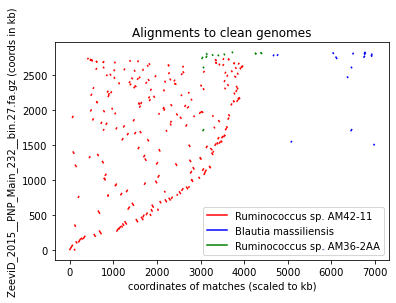

In [22]:
dotplot = StackedDotPlot(legit_alignment)
_ = dotplot.plot()
_ = plt.title('Alignments to clean genomes')

shared w/uncultured Lachnospiraceae bacterium: 40.9kb
shared w/uncultured Clostridium sp.: 35.3kb
shared w/uncultured Bacteroides sp.: 20.0kb


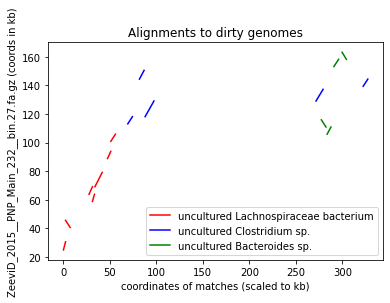

In [23]:
dotplot = StackedDotPlot(alignment)
_ = dotplot.plot()
_ = plt.title('Alignments to dirty genomes')

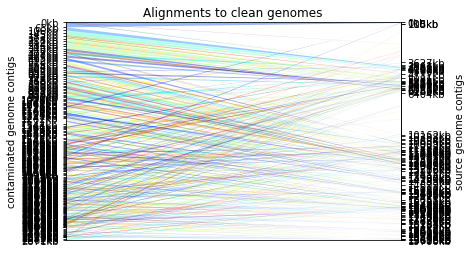

In [24]:
slope = AlignmentSlopeDiagram(legit_alignment)
_ = slope.plot()

_ = plt.title('Alignments to clean genomes')

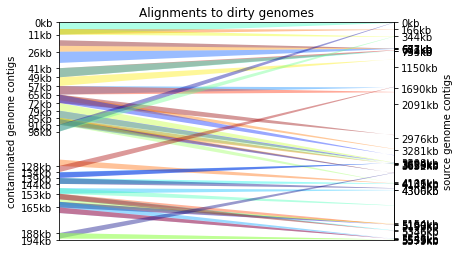

In [25]:
slope = AlignmentSlopeDiagram(alignment)
_ = slope.plot()

_ = plt.title('Alignments to dirty genomes')

## region response curve

underlying logic:

* for our primary use case here (contamination/legitimate "shared" nucleotides), we can consider nt alignments of >= 95% to be contamination to be removed
* we want to remove as many bp of contamination as possible with as little "legit" non-shared nt as possible.
* what's the response curve for that, and can we use it to figure out which genome(s) have the likely contaminants?

22.2kb, 194.3kb


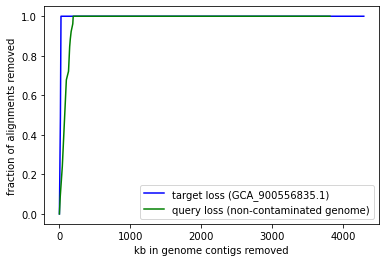

In [26]:
t_acc = alignment.t_acc_list[0]
x, y, sat1 = dotplot.target_response_curve(t_acc)

x3, y3, sat3 = dotplot.query_response_curve()

plt.plot(x, y / max(y), 'b-', label=f'target loss ({t_acc})')
plt.plot(x3, y3 / max(y3), 'g-', label='query loss (non-contaminated genome)')

plt.xlabel('kb in genome contigs removed')
plt.ylabel('fraction of alignments removed')
plt.legend(loc='lower right')
plt.savefig('/tmp/acido-target.png')
print(f'{sat1:.1f}kb, {sat3:.1f}kb')

## Reporting alignments

In [27]:
regions = []
for k, v in alignment.results.items():
    regions.extend(v)

queryfile = alignment.queryfile

# calculate and sort region summed kb in alignments over 95%            
regions_by_query = alignplot.group_regions_by(regions, "query")
regions_aligned_kb = alignplot.calc_regions_aligned_bp(
    regions_by_query, "query", filter_by=lambda r: r.pident >= 95
)
region_items = list(regions_aligned_kb.items())
region_items.sort(key=lambda x: -x[1])
top_name, top_aligned_kb = region_items[0]

In [28]:
for name, aligned_kb in region_items[:5]:
    for alignment in regions_by_query[name]:
        a = alignment
        print(f"{a.query}[{int(a.qstart*1000)}:{int(a.qend*1000)}] aligns to {a.target}[{int(a.tstart*1000)}:{int(a.tend*1000)}] at {a.pident}% identity - {a.qend - a.qstart:.0f} kb")

NODE_1636_length_10949_cov_18.9335_ID_74514[0:10948] aligns to FMGA01000005.1[6069:15607] at 99.029% identity - 11 kb
NODE_1636_length_10949_cov_18.9335_ID_74514[5949:10948] aligns to NZ_DS264418.1[17275:22274] at 93.1337% identity - 5 kb
NODE_1636_length_10949_cov_18.9335_ID_74514[5949:10948] aligns to NZ_CYYV01000001.1[26684:31683] at 93.1337% identity - 5 kb
NODE_1066_length_15299_cov_16.0749_ID_82401[10000:15298] aligns to USQB01000434.1[0:3683] at 98.6104% identity - 5 kb
NODE_1066_length_15299_cov_16.0749_ID_82401[5000:9999] aligns to USQB01000679.1[0:2190] at 96.8073% identity - 5 kb
NODE_1121_length_14688_cov_13.1937_ID_33847[0:9999] aligns to USQB01000041.1[483:8336] at 97.3522% identity - 10 kb
NODE_2349_length_8173_cov_17.8031_ID_616[0:8172] aligns to FMGA01000027.1[23590:31196] at 98.5875% identity - 8 kb
NODE_2349_length_8173_cov_17.8031_ID_616[0:8172] aligns to FR889750.1[5342:0] at 97.9534% identity - 8 kb
NODE_2502_length_7739_cov_13.9318_ID_82907[0:7738] aligns to NZ_D